In [1]:
import pandas as pd
import numpy as np
import multibind as mb
from multibind import MultibindScanner
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glob import glob
from scipy import constants
import matplotlib as mpl
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import font_manager as fm
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = '10'

# Load files

In [2]:
pHs = [5.6, 6.0, 6.5, 7.0, 7.4]
target = glob('target/*.csv')
concentrations = [np.array([1])]
for csv in target:
    df = pd.read_csv(csv)
    concentrations.append(df.Dose)

In [3]:
data = defaultdict()
for ph in pHs:
    df = pd.read_csv('target/pH{}.csv'.format(ph))
    data[ph] = df

# Run multibind to obtain microstate probabilities

In [4]:
from matplotlib.ticker import FormatStrFormatter,MultipleLocator
import matplotlib

In [12]:
concentrations = np.linspace(-12,1,261)
concen = {'pH': pHs, 'Zn': 10**(concentrations)}
scanner = MultibindScanner('state.csv', 'result.csv')
scanner.run(concen)

In [11]:
msp = scanner.results.microstate_probs
expected = defaultdict()
for p in pHs:
    prob = np.dot(np.array(scanner.c.states.Zn), msp.sel({'pH': p}).values)
    expected[p] = prob

# Fig. 4

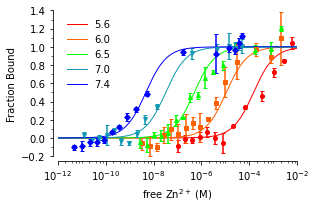

In [7]:
plt.ion()
figure, ax = plt.subplots(figsize=[4.5, 3])
sns.despine(ax=ax, offset=5)

plot_ph = defaultdict()
colors = ['#ff0000', '#ff6000', '#00ff00', '#0f99b2', '#0000ff']
symbol = ['o', 's', '^', 'v', 'D']
for ph, color, symb in zip(pHs, colors, symbol):
    uptake_line, = ax.plot(10**concentrations, expected[ph], color=color, label=str(ph), linewidth=1)
    ax.errorbar(data[ph].Dose, data[ph].Response, yerr=data[ph]['Err-Values'], color=color, capsize=2, fmt=symb, markersize=4)
ax.set_ylabel(r"Fraction Bound")
ax.set_xlabel(r"free Zn$^{2+}$ (M)")
ax.set_xscale("log", nonpositive='clip')
ax.set_ylim([-0.2, 1.4])
ax.set_xlim([1e-12, 0.01])
ax.legend(frameon=False)
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8,1),numticks=12)
locmaj = matplotlib.ticker.LogLocator(base=10.0,numticks=6)
ax.set_yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0,1.2,1.4])
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.tight_layout()
plt.savefig('MC_siteA.pdf', dpi=300)

# Suppl. Fig. 10

In [ ]:
def Hill(ph, n, pka):
    S = 1/(1+10**(n*(pka-ph)))
    return S

In [41]:
concentrations = np.linspace(-12,-2,201)
concen = {'pH': pHs, 'Zn': [1]}
scanner = MultibindScanner('state.csv', 'result.csv')
scanner.run(concen)

In [56]:
kds = []
for i in pHs:
    kd = np.sum(np.exp(-scanner.results.loc[dict(pH=i)].free_energy.values[:16]))/np.sum(np.exp(-scanner.results.loc[dict(pH=5.6)].free_energy.values[16:]))
    kds.append(kd)

In [5]:
pHs = np.linspace(1.5, 11.5, 101)
concentrations = [10**(-20)]
concentrations = np.array(concentrations)
concen = {'pH': pHs, 'Zn': concentrations}
scanner = MultibindScanner('state.csv', 'result.csv')
scanner.run(concen)

In [6]:
msp = scanner.results.microstate_probs
c=1e-20
prob = msp.sel({'Zn': c}).values

In [8]:
proton_0 = np.zeros([16])
proton_1 = np.zeros([16])
proton_2 = np.zeros([16])
proton_3 = np.zeros([16])
proton_4 = np.zeros([16])
proton_0[0] = 1
proton_1[[1,2,4,8]] = 1
proton_2[[3,5,6,9,10,12]] = 1
proton_3[[7,11,13,14]] = 1
proton_4[15] = 1

In [10]:
p_0 = np.dot(proton_0, prob[:16])
p_1 = np.dot(proton_1, prob[:16])
p_2 = np.dot(proton_2, prob[:16])
p_3 = np.dot(proton_3, prob[:16])
p_4 = np.dot(proton_4, prob[:16])

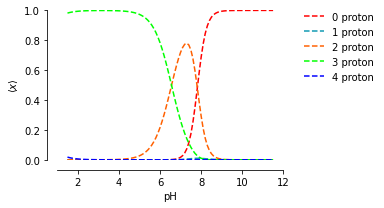

In [12]:
fig = plt.figure(figsize=(5.5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)

ax.set_xlabel(r"pH")
ax.set_ylabel(r"$\langle x \rangle$")

plt.plot(pHs, p_0, '--', label='0 proton', color='#ff0000')
plt.plot(pHs, p_1, '--', label='1 proton', color='#0f99b2')
plt.plot(pHs, p_2, '--', label='2 proton', color='#ff6000')
plt.plot(pHs, p_3, '--', label='3 proton', color='#00ff00')
plt.plot(pHs, p_4, '--', label='4 proton', color='blue')

ax.legend(ncol=1, frameon=False, bbox_to_anchor=(1.05, 1.05))
ax.set_ylim([0,1])
plt.tight_layout()
plt.savefig('proton.pdf', dpi=300)

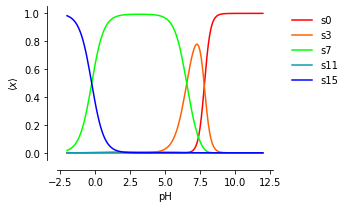

In [10]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)
ax.set_ylabel(r"$\langle x \rangle$")
ax.set_xlabel(r"pH")

labels = ['s{}'.format(i) for i in range(0,16)] +  ['s{}Zn'.format(i) for i in range(0,16)]
for i in range(0,32):
    if i==0:
        color='#ff0000'
        ax.plot(pHs, prob[i,:], label=labels[i], color=color)
    elif i==3:
        color='#ff6000'
        ax.plot(pHs, prob[i,:], label=labels[i], color=color)
    elif i==7:
        color='#00ff00'
        ax.plot(pHs, prob[i,:], label=labels[i], color=color)
    elif i==11:
        color='#0f99b2'
        ax.plot(pHs, prob[i,:], label=labels[i], color=color)
    elif i==15:
        color='blue'
        ax.plot(pHs, prob[i,:], label=labels[i], color=color)

ax.legend(ncol=1, frameon=False, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('pH.pdf', dpi=300)

In [17]:
state = pd.read_csv('state.csv')

In [6]:
diamond0 = np.array([1-(i or j) for i,j in zip(state.D159, state.H155)])

In [7]:
diamond1_D159 = np.array([(i and (not j)) for i,j in zip(state.D159, state.H155)])
diamond1_H155 = np.array([((not i) and j) for i,j in zip(state.D159, state.H155)])

In [8]:
diamond2 = np.array([(i and j) for i,j in zip(state.D159, state.H155)])

In [9]:
diamond1_H155

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [54]:
def pka_p(ph, pka):
    return pka-ph

In [53]:
diamond0_curve = np.dot(diamond0, prob[:16,:])
diamond1_D159_curve  = np.dot(diamond1_D159 , prob[:16,:])
diamond1_H155_curve = np.dot(diamond1_H155, prob[:16,:])
diamond2_curve = np.dot(diamond2, prob[:16,:])

In [6]:
D47_curve = np.dot(state.D47, prob[:16,:])
D51_curve = np.dot(state.D51, prob[:16,:])
D159_curve = np.dot(state.D159, prob[:16,:])
H155_curve = np.dot(state.H155, prob[:16,:])

In [9]:
from scipy.optimize import curve_fit

In [8]:
def Hill(ph, n, pka):
    S = 1/(1+10**(n*(pka-ph)))
    return S

In [8]:
def couple(ph, pka1, pka2):
    S = 1/(1+10**(pka1-ph))  +1/(1+10**(pka2-ph))
    return S

[2.03398141 7.8290282 ]
[[5.02023531e-06 7.44899615e-14]
 [7.44899615e-14 7.13592809e-08]]


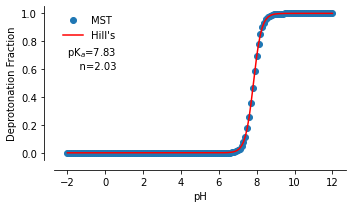

In [10]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)
ax.set_ylabel(r"Deprotonation Fraction")
ax.set_xlabel(r"pH")

popt, pcov = curve_fit(Hill, pHs, 1-H155_curve, p0=[1,8], maxfev=100000)
fit155 = Hill(pHs, 2.03410132, 7.8290255)
print(popt)
print(pcov)
ax.plot(pHs, 1-H155_curve, 'o', linewidth=0.5, label='MST')
ax.plot(pHs, fit155, color='#ff0000', label='Hill\'s')

ax.legend(loc='upper left', frameon=False)
ax.text(-2, 0.6, u'pK$_{a}$=7.83 \n    n=2.03')
plt.tight_layout()
plt.savefig('Hill_H155.pdf', dpi=300)

[2.03545098 7.82379662]


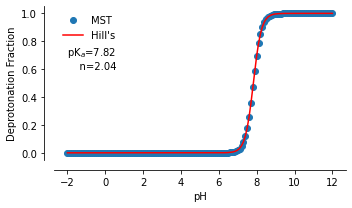

In [11]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)
ax.set_ylabel(r"Deprotonation Fraction")
ax.set_xlabel(r"pH")

popt, pcov = curve_fit(Hill, pHs, 1-D159_curve, p0=[1,8], maxfev=100000)
fit159 = Hill(pHs, popt[0], popt[1])
print(popt)
ax.plot(pHs, 1-D159_curve, 'o', linewidth=0.5, label='MST')
ax.plot(pHs, fit159, color='#ff0000', label='Hill\'s')

ax.legend(loc='upper left', frameon=False)
ax.text(-2, 0.6, u'pK$_{a}$='+'{:1.2f} \n    n={:1.2f}'.format(popt[1], popt[0]))
plt.tight_layout()
plt.savefig('Hill_H159.pdf', dpi=300)

[1.02897528 6.54287774]


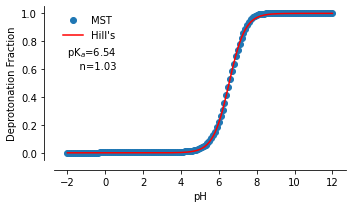

In [12]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)
ax.set_ylabel(r"Deprotonation Fraction")
ax.set_xlabel(r"pH")

popt, pcov = curve_fit(Hill, pHs, 1-D51_curve, p0=[1,8], maxfev=100000)
fit51 = Hill(pHs, popt[0], popt[1])
print(popt)
ax.plot(pHs, 1-D51_curve, 'o', linewidth=0.5, label='MST')
ax.plot(pHs, fit51, color='#ff0000', label='Hill\'s')

ax.legend(loc='upper left', frameon=False)
ax.text(-2, 0.6, u'pK$_{a}$='+'{:1.2f} \n    n={:1.2f}'.format(popt[1], popt[0]))
plt.tight_layout()
plt.savefig('Hill_D51.pdf', dpi=300)

[ 0.98725126 -0.22878026]


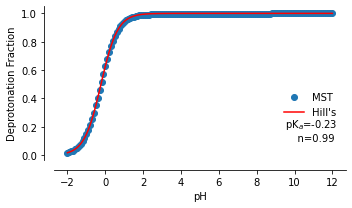

In [13]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)
ax.set_ylabel(r"Deprotonation Fraction")
ax.set_xlabel(r"pH")
popt, pcov = curve_fit(Hill, pHs, 1-D47_curve, p0=[1,0], maxfev=100000)
fit47 = Hill(pHs, popt[0], popt[1])
print(popt)
ax.plot(pHs, 1-D47_curve, 'o', linewidth=0.5, label='MST')
ax.plot(pHs, fit47, color='#ff0000', label='Hill\'s')

ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5), frameon=False)
ax.text(9.5, 0.1, u'pK$_{a}$='+'{:1.2f} \n    n={:1.2f}'.format(popt[1], popt[0]))
plt.tight_layout()
plt.savefig('Hill_D47.pdf', dpi=300)

[ 0.98725126 -0.22878026]
[1.02897528 6.54287774]
[2.03398141 7.8290282 ]
[[5.02023531e-06 7.44899615e-14]
 [7.44899615e-14 7.13592809e-08]]
[2.03545098 7.82379662]


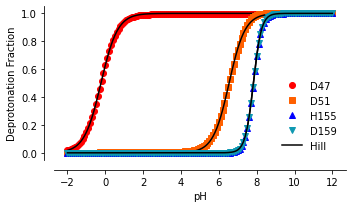

In [26]:
colors = ['#ff0000', '#ff6000', '#00ff00', '#0f99b2', '#0000ff']
symbol = ['o', 's', '^', 'v', 'D']
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 1, 1)
sns.despine(offset=10, ax=ax)
ax.set_ylabel(r"Deprotonation Fraction")
ax.set_xlabel(r"pH")

popt, pcov = curve_fit(Hill, pHs, 1-D47_curve, p0=[1,0], maxfev=100000)
fit47 = Hill(pHs, popt[0], popt[1])
print(popt)
ax.plot(pHs, 1-D47_curve, 'o', color='#ff0000', linewidth=0.5, label='D47')
ax.plot(pHs, fit47, color='k')

popt, pcov = curve_fit(Hill, pHs, 1-D51_curve, p0=[1,8], maxfev=100000)
fit51 = Hill(pHs, popt[0], popt[1])
print(popt)
ax.plot(pHs, 1-D51_curve, 's', color='#ff6000', linewidth=0.5, label='D51')
ax.plot(pHs, fit51, color='k')

popt, pcov = curve_fit(Hill, pHs, 1-H155_curve, p0=[1,8], maxfev=100000)
fit155 = Hill(pHs, 2.03410132, 7.8290255)
print(popt)
print(pcov)
ax.plot(pHs, 1-H155_curve, '^', color='#0000ff', linewidth=0.5, label='H155')
ax.plot(pHs, fit155, color='k')

popt, pcov = curve_fit(Hill, pHs, 1-D159_curve, p0=[1,8], maxfev=100000)
fit159 = Hill(pHs, popt[0], popt[1])
print(popt)
ax.plot(pHs, 1-D159_curve, 'v', color='#0f99b2', linewidth=0.5, label='D159')
ax.plot(pHs, fit159, color='k', label='Hill')
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.savefig('Hill.pdf', dpi=300)
